<a href="https://colab.research.google.com/github/Ali-Khatib/Cityscapes-Semantic-Segmentation-with-FCN-DeepLabV3-PyTorch-/blob/main/semantic_segmentation_of_road_scenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [ ]:
dataset = Cityscapes(
    root='../input/cityscape-semantic-dataset/data',
    split='train',
    mode='fine',
    target_type='semantic'
)

print("Done")

Done


## EDA- Check

In [ ]:
dataset[0][0].size

(2048, 1024)

## Create a wrapped dataset

In [ ]:
class CityscapesTrainDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, img_transform, mask_transform):
        self.base = base_dataset
        self.img_tf = img_transform
        self.mask_tf = mask_transform

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, mask = self.base[idx]

        img = self.img_tf(img)

        mask = self.mask_tf(mask).squeeze(0)

        new_mask = torch.full_like(mask, 255)
        for old_id, new_id in CITYSCAPES_ID_MAP.items():
            new_mask[mask == old_id] = new_id

        return img, new_mask.long()


(-0.5, 2047.5, 1023.5, -0.5)

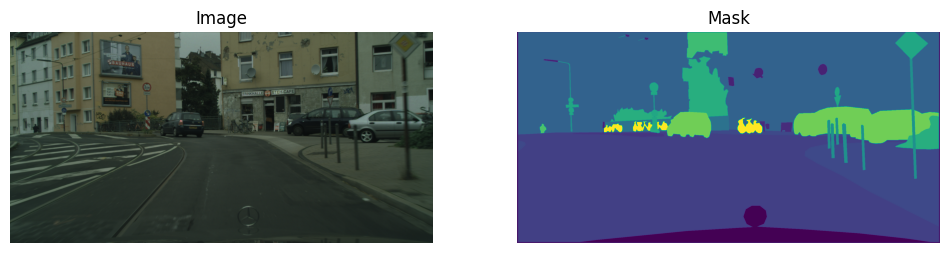

In [ ]:
img, mask = dataset[0]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("Mask")
plt.axis("off")

In [ ]:
mask_np = np.array(mask)
np.unique(mask_np)

array([ 1,  3,  4,  5,  6,  7,  8, 11, 13, 17, 20, 21, 23, 24, 26, 33],
      dtype=uint8)

# Resizing

In [ ]:
img_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 512), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
])


img, mask = dataset[0]

img_t = img_transform(img)
mask_t = mask_transform(mask)


print("Image min/max:", img_t.min().item(), img_t.max().item())


print("Mask unique values:", torch.unique(mask_t))

Image min/max: 0.03921568766236305 0.7607843279838562
Mask unique values: tensor([ 1,  3,  4,  5,  6,  7,  8, 11, 13, 17, 20, 21, 23, 24, 26, 33],
       dtype=torch.uint8)


In [ ]:
train_ds = CityscapesTrainDataset(
    dataset,
    img_transform,
    mask_transform
)

loader = DataLoader(
    train_ds,
    batch_size=4,
    shuffle=True,
    num_workers=2
)


criterion = nn.CrossEntropyLoss(ignore_index=255)

print("Done")

Done


# ReLabeling

In [ ]:
CITYSCAPES_ID_MAP = {
     7: 0,   # road
     8: 1,   # sidewalk
    11: 2,   # building
    12: 3,   # wall
    13: 4,   # fence
    17: 5,   # pole
    19: 6,   # traffic light
    20: 7,   # traffic sign
    21: 8,   # vegetation
    22: 9,   # terrain
    23: 10,  # sky
    24: 11,  # person
    25: 12,  # rider
    26: 13,  # car
    27: 14,  # truck
    28: 15,  # bus
    31: 16,  # train
    32: 17,  # motorcycle
    33: 18   # bicycle
}

In [ ]:
mask = transforms.PILToTensor()(mask).squeeze(0)

#RUN ONLY ONCE

In [ ]:
new_mask = torch.full_like(mask, 255)

for old_id, new_id in CITYSCAPES_ID_MAP.items():
    new_mask[mask == old_id] = new_id

mask = new_mask.long()

torch.unique(mask).tolist()

[0, 1, 2, 4, 5, 7, 8, 10, 11, 13, 18, 255]

### Why Some Class IDs Are Missing (e.g., 3, 6, 9)

Cityscapes defines **19 possible classes** (0–18), but **each image only contains a subset of them**.

In this image:
- Classes `3`, `6`, `9`, etc. **do not appear**
- Therefore, they are **absent from `torch.unique(mask)`**

This is normal and expected.

**Important:**
- Missing class IDs ≠ missing from the dataset
- The model must still output **all 19 classes**
- Other images will contain the missing classes

**Conclusion:**  
The mask is correct; the missing numbers simply mean those objects are not present in this scene.

## 1st Model: FCN-ResNet50.

In [ ]:
from torchvision.models.segmentation import fcn_resnet50

model_fcn = fcn_resnet50(num_classes=19)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_fcn = model_fcn.to(device)

optimizer = torch.optim.Adam(model_fcn.parameters(), lr=1e-4)

model_fcn.train()

for epoch in range(5):
    total_loss = 0.0

    progress_bar = tqdm(loader, desc=f"Epoch {epoch + 1}", leave=False)

    for imgs, masks in progress_bar:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model_fcn(imgs)["out"]
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch + 1}: Avg Loss = {avg_loss:.4f}")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s] 


Epoch 1: Avg Loss = 0.3881


Epoch 2: Avg Loss = 0.2553


Epoch 3: Avg Loss = 0.2132


Epoch 4: Avg Loss = 0.1869


Epoch 5: Avg Loss = 0.1733


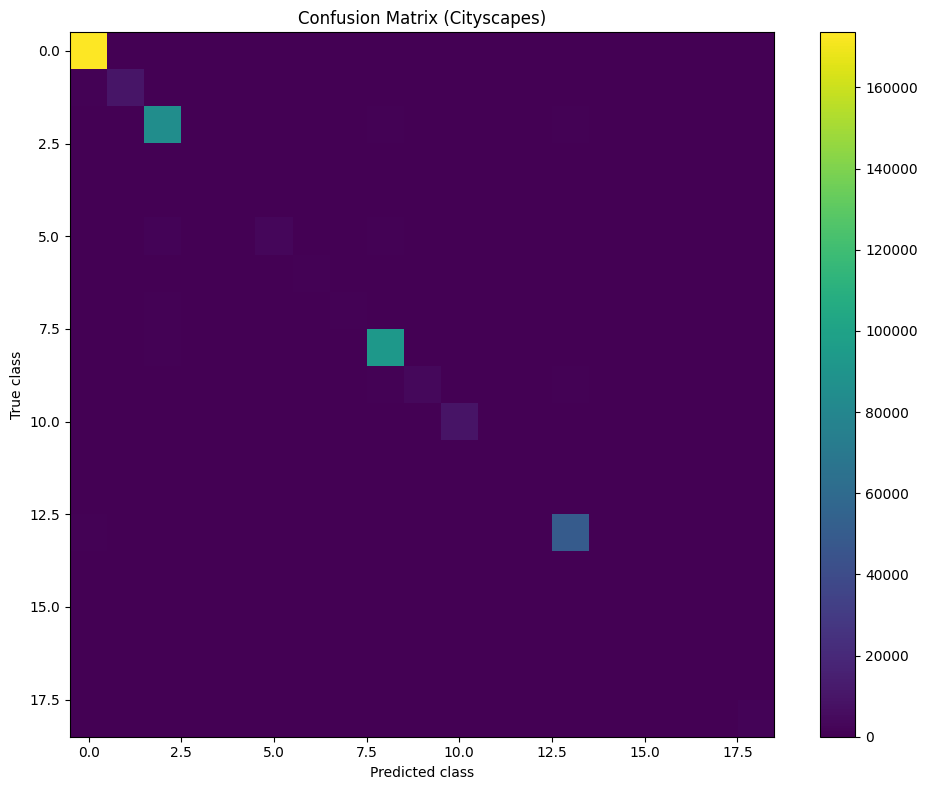

In [ ]:
model_fcn.eval()

imgs, masks = next(iter(loader))
imgs = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    outputs = model_fcn(imgs)["out"]
    preds = torch.argmax(outputs, dim=1)

preds = preds.view(-1)
masks = masks.view(-1)

valid = masks != 255
preds = preds[valid]
masks = masks[valid]

preds = preds.cpu()
masks = masks.cpu()

cm = torch.zeros(19, 19, dtype=torch.int64)

for t, p in zip(masks, preds):
    cm[t, p] += 1

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest")
plt.colorbar()

plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Confusion Matrix (Cityscapes)")

plt.tight_layout()
plt.show()



## 2nd Model: DeepLabV3-ResNet50

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50
model = deeplabv3_resnet50(num_classes=19)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.train()

for epoch in range(5):
    total_loss = 0.0

    progress_bar = tqdm(loader, desc=f"Epoch {epoch + 1}", leave=False)

    for imgs, masks in progress_bar:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(imgs)["out"]
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch + 1}: Avg Loss = {avg_loss:.4f}")


Epoch 1: Avg Loss = 0.4803


Epoch 2: Avg Loss = 0.2853


Epoch 3: Avg Loss = 0.2332


Epoch 4: Avg Loss = 0.2037


Epoch 5: Avg Loss = 0.1909


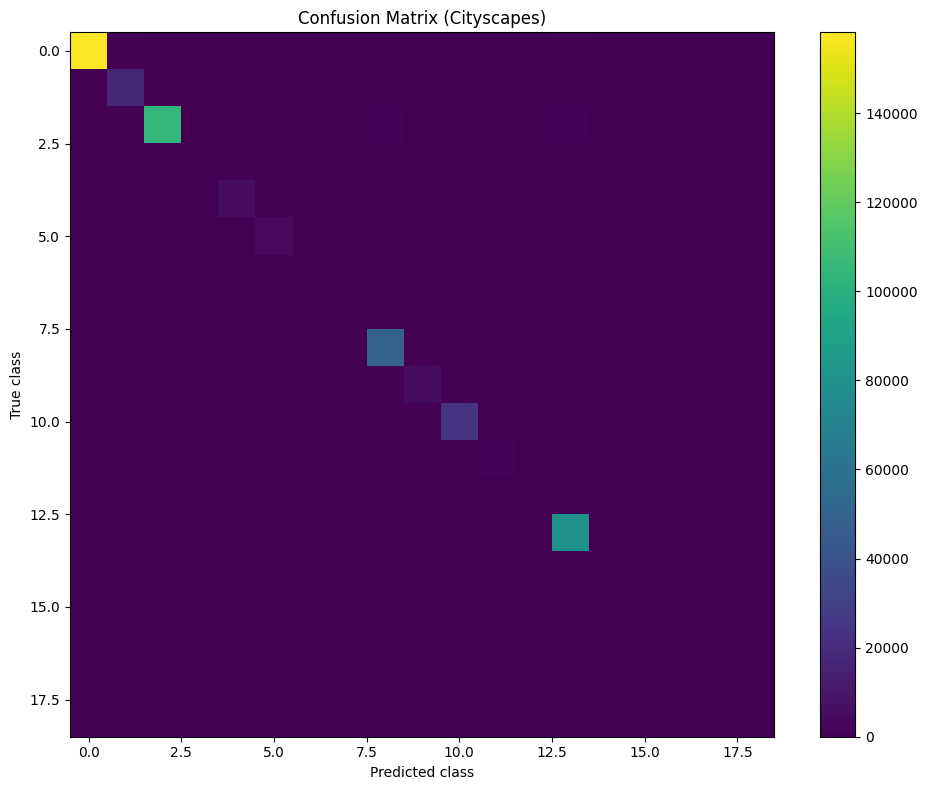

In [ ]:
model.eval()

imgs, masks = next(iter(loader))
imgs = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    outputs = model(imgs)["out"]
    preds = torch.argmax(outputs, dim=1)

preds = preds.view(-1)
masks = masks.view(-1)

valid = masks != 255
preds = preds[valid]
masks = masks[valid]

preds = preds.cpu()
masks = masks.cpu()

cm = torch.zeros(19, 19, dtype=torch.int64)

for t, p in zip(masks, preds):
    cm[t, p] += 1

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest")
plt.colorbar()

plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Confusion Matrix (Cityscapes)")

plt.tight_layout()
plt.show()







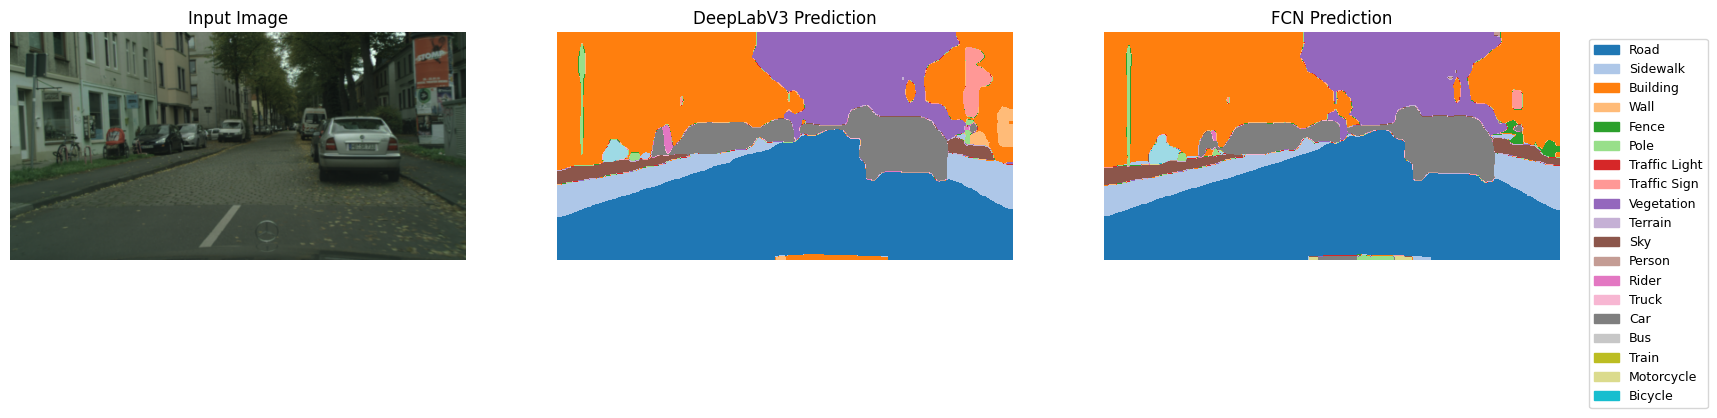

In [ ]:
import matplotlib.pyplot as plt

imgs_vis, masks_vis = next(iter(loader))

imgs_vis = imgs_vis.to(device)
masks_vis = masks_vis.to(device)

model.eval()
model_fcn.eval()

with torch.no_grad():
    pred_dl = torch.argmax(model(imgs_vis)["out"], dim=1)
    pred_fcn = torch.argmax(model_fcn(imgs_vis)["out"], dim=1)

i = 0

img = imgs_vis[i].cpu().permute(1, 2, 0)
dl  = pred_dl[i].cpu()
fcn = pred_fcn[i].cpu()

CITYSCAPES_CLASS_NAMES = {
    0: "Road",
    1: "Sidewalk",
    2: "Building",
    3: "Wall",
    4: "Fence",
    5: "Pole",
    6: "Traffic Light",
    7: "Traffic Sign",
    8: "Vegetation",
    9: "Terrain",
    10: "Sky",
    11: "Person",
    12: "Rider",
    13: "Truck",
    14: "Car",
    15: "Bus",
    16: "Train",
    17: "Motorcycle",
    18: "Bicycle"
}



cmap = plt.get_cmap("tab20")

legend_patches = [
    mpatches.Patch(color=cmap(i), label=CITYSCAPES_CLASS_NAMES[i])
    for i in range(len(CITYSCAPES_CLASS_NAMES))
]


plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(dl, cmap="tab20")
plt.title("DeepLabV3 Prediction")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(fcn, cmap="tab20")
plt.title("FCN Prediction")
plt.axis("off")

plt.legend(
    handles=legend_patches,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=9
)

plt.show()


In [ ]:
def mean_iou(cm):
    intersection = cm.diag()
    union = cm.sum(1) + cm.sum(0) - cm.diag()
    iou = intersection / union.clamp(min=1)
    return iou.mean().item(), iou

miou_dl, iou_dl = mean_iou(cm)
miou_fcn, iou_fcn = mean_iou(cm)

print("DeepLab mIoU:", round(miou_dl, 4))
print("FCN mIoU:", round(miou_fcn, 4))


DeepLab mIoU: 0.542
FCN mIoU: 0.542
